# Networks
The purpose of this notebook is to create a visualization of the network given our features, parameters, and sub-parameters for a logistic regression model.

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns
import statsmodels.api as sm
import networkx as nx
import scipy as sc
import pickle
sns.set_theme(context="notebook", font_scale=1.2)
import warnings
warnings.filterwarnings('ignore')

In [2]:
scaler = MinMaxScaler()

## Preprocessing
Using the relevant features found in `EDA.ipynb`, we perform mean value imputation and normalize each feature to be in the range $[0,1]$.

In [3]:
with open('feat_cols.pkl', 'rb') as f:
    feat_cols = pickle.load(f)

In [4]:
data = pd.read_csv("ld_clean.csv")
status = data['Status']
data = data[feat_cols + ['Status']]
data = data.infer_objects()
data.fillna(data.mean(), inplace=True)
#data[feat_cols] = scaler.fit_transform(data[feat_cols])
data.head()

,co-applicant_credit_type_EXP,Gender_Joint,total_units_3U,Upfront_charges,Neg_ammortization_neg_amm,construction_type_mh,Secured_by_land,Security_Type_Indriect,occupancy_type_sr,Region_North,...,age_<25,approv_in_adv_nopre,age_35-44,lump_sum_payment_lpsm,credit_type_CIB,income,loan_limit_ncf,loan_purpose_p1,LTV,Status
0,0,0,0,595.0,1,0,0,0,0,0,...,0,0,1,0,0,9480.0,0,1,80.019685,0
1,0,0,0,595.0,0,0,0,0,0,1,...,0,1,0,0,0,11880.0,0,0,69.376900,0
2,1,1,0,0.0,0,0,0,0,0,1,...,0,0,0,0,0,10440.0,0,1,91.886544,0
3,1,1,0,370.0,0,0,0,0,0,1,...,0,0,1,0,0,10080.0,0,1,70.089286,0
4,1,1,0,5120.0,0,0,0,0,0,1,...,0,0,0,0,0,5040.0,0,0,79.109589,0


## Network Visualization

We now construct a network for all of our parameters. Since the sub-parameters for each $\beta$ vary, each $\beta$ will have it's own $\mu$ and $\sigma^2$.

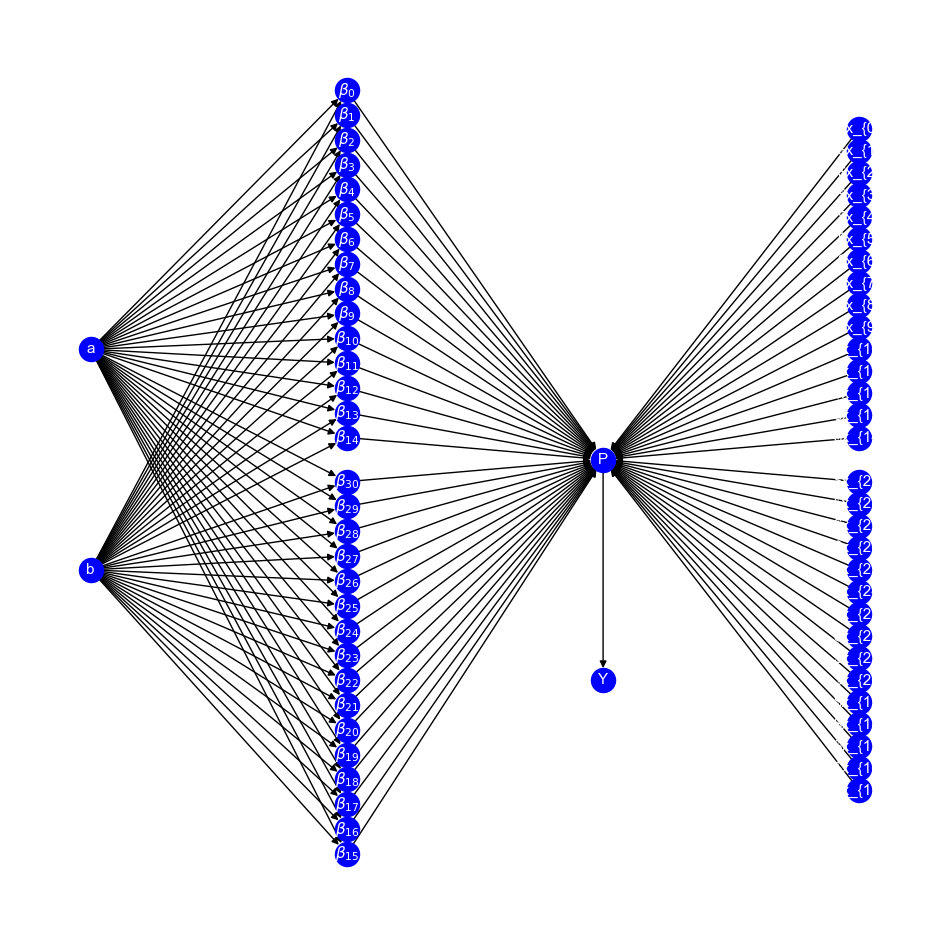

In [5]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()
G.add_node('a')
G.add_node('b')
for i in range(31):
    G.add_node(f'$\\beta_{{{i}}}$')
for i in range(30):
    G.add_node(f'$x_{{{i}}}')
G.add_node('P')
G.add_node('Y')

for i in range(31):
    G.add_edge('a', f'$\\beta_{{{i}}}$')
    G.add_edge('b', f'$\\beta_{{{i}}}$')
    G.add_edge(f'$\\beta_{{{i}}}$', 'P')
for i in range(30):
    G.add_edge(f'$x_{{{i}}}', 'P')
G.add_edge('P', 'Y')

pos = {}
pos['a'] = (-8, 2)
pos['b'] = (-8, -2)
for i in range(15):
    pos[f'$\\beta_{{{i}}}$'] = (-4, 6.7 - i*0.45)
for i in range(15,31):
    pos[f'$\\beta_{{{i}}}$'] = (-4, -6.7 + (i-16)*0.45)
pos['P'] = (0, 0)
pos['Y'] = (0, -4)
for i in range(15):
    pos[f'$x_{{{i}}}'] = (4, 6 - i*0.4)
for i in range(15, 30):
    pos[f'$x_{{{i}}}'] = (4, -6 + (i-15)*0.4)

# Visualize the graph with even more spacing
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G, pos, node_size=300, node_color='blue')
nx.draw_networkx_edges(G, pos, edge_color='black', width=1)
nx.draw_networkx_labels(G, pos, font_color='white', font_size=11)
plt.axis('off')
plt.show()


In [6]:
G_moral = nx.moral_graph(G)

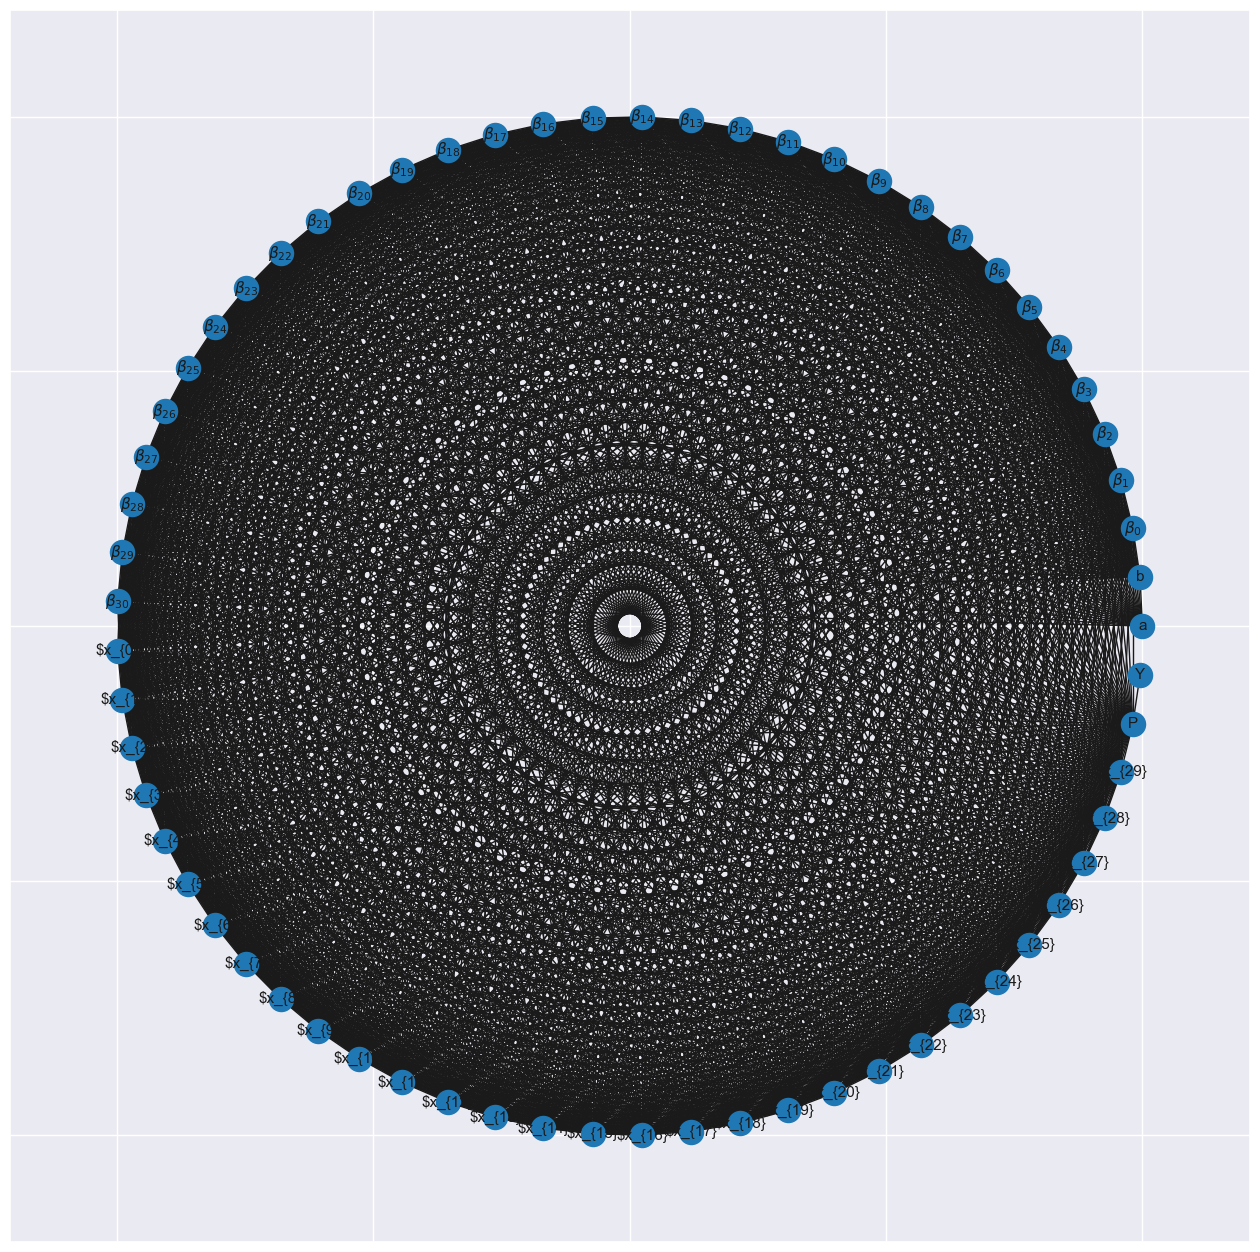

In [7]:
layout = nx.circular_layout(G_moral)
plt.figure(figsize=(16,16))
nx.draw_networkx_nodes(G_moral, layout, node_size=300)
nx.draw_networkx_labels(G_moral, layout, font_size=11)
nx.draw_networkx_edges(G_moral, layout)
plt.show()